# Deep Black-Box Optimization with Monte Carlo Dropout: Ackley

Comparing GP-LCB, NN-INF, and NN-MCD.

In [1]:
from exp_sim_optim_simple import (
    setup_objective,
    run_sim_optim_gp,
    run_sim_optim_tf2,
    run_sim_optim_mcd_tf2,
    eval_hook,
    report_result,
    plot_regrets,
    plot_surface,
)
from exputils.models_tf import make_fcnet

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
print("tensorflow:", tf.__version__)

tensorflow: 2.4.1


## Problem: Finding Minimum of the 2D Ackley Function

In [3]:
np.random.seed(1)
tf.random.set_seed(3)

In [4]:
# Common arguments
input_dim = 2
init_points = 1
max_iter = 200
# NN model arguments
layer_sizes = [8, 8, 4]
dropout = 0.1

In [5]:
problem, domain, X, Y = setup_objective(
    "Ackley", 
    input_dim,
    init_points,
)

## Baseline: GP-LCB

minimum: 0.04001830580339982
minimizer: [-0.0124234  -0.00235778]
elapsed time: 122.54 seconds


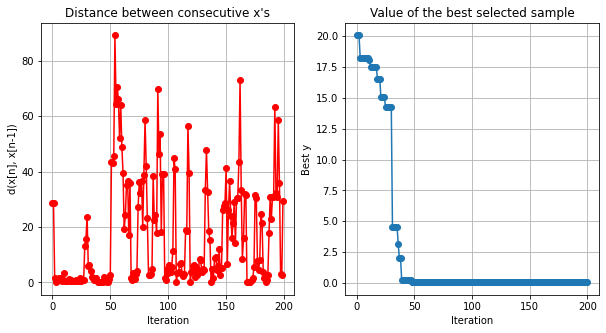

In [6]:
# ~45 seconds on laptop
gp_opt = run_sim_optim_gp(
    problem,
    domain,
    X,
    Y,
    max_iter=max_iter,
    acquisition_type="LCB",
)

## NN-MCD

Optimizing:   0%|          | 0/200 [00:00<?, ?it/s]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2)                 0         
_________________________________________________________________
dense (Dense)                (None, 8)                 24        
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 36        
_________________________________________________________________
dropout_2 (Dropout)          (None, 4)                 0

Optimizing: 100%|██████████| 200/200 [02:15<00:00,  1.48it/s, R_i=3.15, exp_w=82, f*hat=3.15, fhat_i=3.28, r_i=3.28, t_i=0.5, y_i=3.28, μ*=3.31, σ*=2]      


Elapsed Time: 135.55s
predicted minimum value: 3.348914384841919 +/- 2.000000238418579
predicted minimizer: [0.74291945 0.05220161]
actual value at predicted minimizer: 3.147569179534912


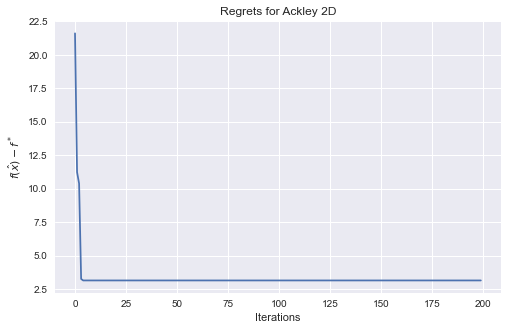

In [7]:
# ~120 seconds
nnmcd_tf2 = run_sim_optim_mcd_tf2(
    problem,
    domain,
    layer_sizes=layer_sizes,
    dropout=dropout,
    n_dropout_samples=100,
    lengthscale=1e-2,
    tau=0.25,
    max_iter=max_iter,
)

## NN-INF

Optimizing:   0%|          | 0/200 [00:00<?, ?it/s]

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 24        
_________________________________________________________________
dropout_3 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 72        
_________________________________________________________________
dropout_4 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 36        
_________________________________________________________________
dropout_5 (Dropout)          (None, 4)                

Optimizing: 100%|██████████| 200/200 [06:08<00:00,  1.84s/it, R_i=20.8, exp_w=82, f*hat=20.8, fhat_i=21.8, r_i=21.8, t_i=2.57, y_i=21.8, μ*=21.7, σ*=0.214]   


Elapsed Time: 368.67s
predicted minimum value: 21.738441467285156 +/- 0.15419165790081024
predicted minimizer: [16.93451931  5.14289392]
actual value at predicted minimizer: 18.921733030778988


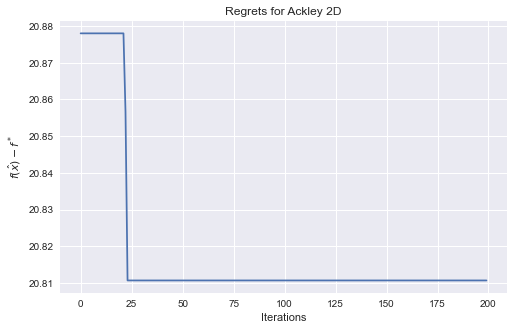

In [8]:
# ~250 seconds
nninf_tf2 = run_sim_optim_tf2(
    problem,
    domain,
    layer_sizes=layer_sizes,
    dropout=dropout,
    max_iter=max_iter,
)

## Combined Results

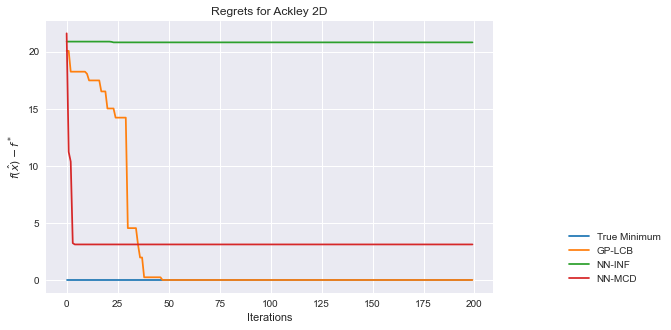

In [9]:
plot_regrets(
    [np.repeat(0, max_iter), 
     gp_opt.Y_best[-max_iter:] - problem.fmin, 
     nninf_tf2["regrets"], 
     nnmcd_tf2["regrets"]],
    problem.name, 
    ["True Minimum", "GP-LCB", "NN-INF", "NN-MCD"],
)

True Minimum    : min 0.00000 at [0.0, 0.0]
GP-LCB          : min 0.04002 at [-0.0124234  -0.00235778]
NN-INF          : min 18.92173 at [16.93451931  5.14289392]
NN-MCD          : min 3.14757 at [0.74291945 0.05220161]


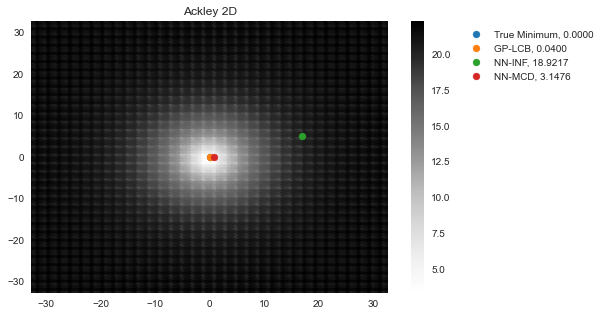

In [10]:
# NN Surface
minimizers = [
    (problem.min, problem.fmin, "True Minimum"),
    (gp_opt.x_opt, gp_opt.fx_opt, "GP-LCB"),
    (nninf_tf2["bo"].x_opt, nninf_tf2["bo"].fx_opt, "NN-INF"),
    (nnmcd_tf2["bo"].x_opt, nnmcd_tf2["bo"].fx_opt, "NN-MCD"),
]

plot_surface(problem, problem.bounds[0][1], minimizers, problem.name)